# A/B Testing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, \
    f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
from scipy.stats import shapiro
import scipy.stats as levene
from IPython.display import Image

## What is A/B Testing? 

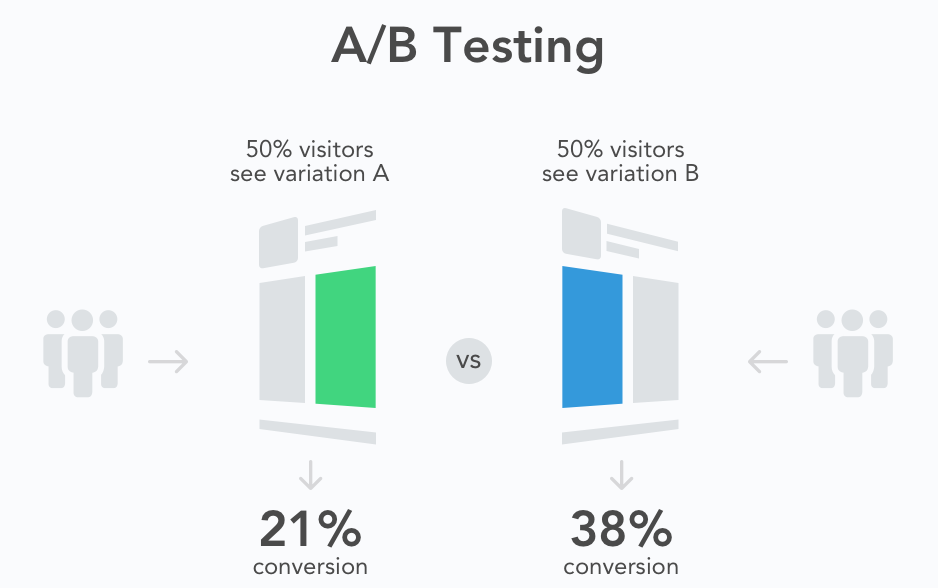

In [2]:
Image("ab_testing.png")

### A/B testing is a type of split testing and is commonly used to drive improvements to specific variables or elements by measuring user or audience engagement. The approach is commonly used to optimise marketing campaigns or digital assets like websites. 

## Data Preparation and Descriptive Analysis

In [3]:
control = pd.read_excel("ab_testing.xlsx", sheet_name='Control Group')  # maximum bidding
test = pd.read_excel("ab_testing.xlsx", sheet_name='Test Group')        # average bidding
control = control.iloc[:, :4]
test = test.iloc[:, :4]

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T)

In [5]:
check_df(control)

##################### Shape #####################
(40, 4)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Impression  40 non-null     float64
 1   Click       40 non-null     float64
 2   Purchase    40 non-null     float64
 3   Earning     40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB
None
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object
##################### Head #####################
      Impression        Click    Purchase      Earning
0   82529.459271  6090.077317  665.211255  2311.277143
1   98050.451926  3382.861786  315.084895  1742.806855
2   82696.023549  4167.965750  458.083738  1797.827447
3  109914.400398  4910.882240  487.090773  1696.229178
4  108457.762630  5987.6

In [6]:
check_df(test)

##################### Shape #####################
(40, 4)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Impression  40 non-null     float64
 1   Click       40 non-null     float64
 2   Purchase    40 non-null     float64
 3   Earning     40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB
None
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object
##################### Head #####################
      Impression        Click    Purchase      Earning
0  120103.503796  3216.547958  702.160346  1939.611243
1  134775.943363  3635.082422  834.054286  2929.405820
2  107806.620788  3057.143560  422.934258  2526.244877
3  116445.275526  4650.473911  429.033535  2281.428574
4  145082.516838  5201.3

In [7]:
# Analyze the dataframes 
def analyze_df (df):
    print("Shape of dataframe: {0}".format(df.shape)) # shape of dataframe
    print("There are {0} observations and {1} features".format(len(df),len(df.columns))) # number of observations and features
    print("Website Click Through Rate: %.4f" % (df["Click"].sum()/df["Impression"].sum()*100),"%","\n") # rate of website click

In [8]:
analyze_df(control)

Shape of dataframe: (40, 4)
There are 40 observations and 4 features
Website Click Through Rate: 5.0148 % 



In [9]:
analyze_df(test)

Shape of dataframe: (40, 4)
There are 40 observations and 4 features
Website Click Through Rate: 3.2922 % 



In [10]:
A = pd.DataFrame(control["Purchase"])
B = pd.DataFrame(test["Purchase"])

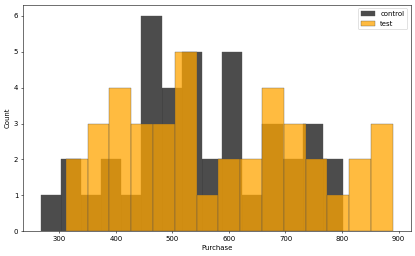

In [25]:
fig = plt.figure(figsize=(10,6), dpi = 50)

fig = sns.histplot(
    x=control['Purchase'],
    palette="light:m_r",
    color = 'black',
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    alpha = .7,
    bins = 15,
    legend = True
)
fig = sns.histplot(
    x=test['Purchase'],
    color = 'orange',
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    bins = 15,
    legend = True
)
fig.legend(labels=['control','test'], loc='upper right')

plt.show()

In [12]:
AB = pd.concat([A,B],axis=1)
AB.columns=["A","B"]
AB.head()

,A,B
0,665.211255,702.160346
1,315.084895,834.054286
2,458.083738,422.934258
3,487.090773,429.033535
4,441.034050,749.860442


In [13]:
print(" Mean of purchase of control group: %.3f"%AB.A.mean(),"\n",
      "Mean of purchase of test group: %.3f"%AB.B.mean())

 Mean of purchase of control group: 550.894 
 Mean of purchase of test group: 582.106


In [30]:
# There doesn't seem to be much difference between purchases, according to maximum bidding or average bidding. 
# We need to run a hypothesis test to see if there's a statistically significant difference between the two groups.

#### H0= There is no statistically significant difference between the purchasing averages of control and test groups. μ0 = μ1
#### H1= There is a statistically significant difference between the purchasing averages of control and test groups. μ0 <> μ1  

## The Shapiro-Wilks Test for Normality

### The Shapiro-Wilk test is a test for normal distribution exhibiting high power, leading to good results even with a small number of observations. In contrast to other comparison tests the Shapiro-Wilk test is only applicable to check for normality.

#### H0 : Normal distribution assumption is provided 
#### H1 : Normal distribution assumption is not provided

### Control

In [14]:
test_statistic , pvalue = shapiro(AB.A)
print('Test statistic = %.4f, p-Value = %.4f' % (test_statistic, pvalue))

Test statistic = 0.9773, p-Value = 0.5891


In [26]:
#p-value greater than 0.05 so H0 is not rejected for Group A.
pvalue < 0.05

False

### Test

In [16]:
test_statistic , pvalue = shapiro(AB.B)
print('Test statistic = %.4f, p-Value = %.4f' % (test_statistic, pvalue))

Test statistic = 0.9589, p-Value = 0.1541


In [27]:
#p-value greater than 0.05 so H0 is not rejected for Group B.
pvalue < 0.05

False

In [32]:
# H0 cannot be rejected because p-value = 0.1541 and 0.5891 > 0.05, 
# hence, the normal distribution assumption of is provided. 
# Then, we should take a look at the homogenity of variance. 

## Levene’s Test for Homogeneity of variances

###  Levene's test is an inferential statistic used to assess the equality of variances for a variable calculated for two or more groups. 

#### H0: Variances are homogeneous.
#### H1: Variances are not homogeneous.

In [18]:
test_statistic, pvalue = stats.levene(AB.A,AB.B)
print('Test statistic = %.4f, p-Value = %.4f' % (test_statistic, pvalue))

Test statistic = 2.6393, p-Value = 0.1083


In [34]:
# p-value greater than 0.05 so H0 is not rejected.
pvalue < 0.05

False

In [20]:
tvalue, pvalue = stats.ttest_ind(AB["A"], AB["B"], equal_var=True)
print('tvalue = %.4f, pvalue = %.4f' % (tvalue, pvalue))

tvalue = -0.9416, pvalue = 0.3493


In [33]:
# p-value greater than 0.05 so H0 is not rejected.
pvalue < 0.05

False

In [35]:
# H0 cannot be rejected because p-value = 0.1083 > 0.05, so that is, homogeneous variance distribution is provided.
# Since the assumptions are made, we will perform two independent sample t tests. (parametric test)

## Independent Samples T Test

### The Independent Samples t Test compares the means of two independent groups in order to determine whether there is statistical evidence that the associated population means are significantly different.

## Mann–Whitney U test


### The Mann-Whitney U test is a nonparametric test that allows two groups or conditions or treatments to be compared without making the assumption that values are normally distributed.

In [37]:
test_stat, pvalue = ttest_ind(control["Purchase"],
                              test["Purchase"],
                              equal_var=True)

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -0.9416, p-value = 0.3493


In [40]:
# H0 cannot be rejected because p-value = 0.3493 > 0.05. 
# In other words, there is no statistically significant difference between the purchase averages of the control and test groups.

In [41]:
# According to the test results, H0 is undeniable.
# There is no significant difference between maximum bidding and average bidding. 
# In both cases, purchases are relatively close to each other. 
# As a result, it can be directed to whichever price offer is more suitable. to pay less and get the same purchases. 